**Load and Normalize CIFAR10**

In [ ]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124 --user
!pip install tqdm

In [14]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
from torch import optim
from torch import nn
from tqdm import tqdm

### **Hyperparameters**

In [15]:
# num_classes = 10  #(Havent passed but can be used as parameter to Cnn and can be used in fc layer in init)
learning_rate = 0.001
# batch_size = 64
num_epochs = 5

In [16]:
# Define path to custom image
cats_path = r'.\MyDataset'

In [17]:
transform = transforms.Compose([transforms.Resize((32,32)),transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
batch_size = 64

# trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

# testset = torchvision.datasets.CIFAR10(root='./data', train = False, download=True, transform=transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

dataset = ImageFolder(root=cats_path, transform=transform)
classes = ('cat','random')


In [18]:
# Split into training set and test set (80-20)
train_size = int(0.8*len(dataset))
test_size = len(dataset) - train_size

trainset, testset = torch.utils.data.random_split(dataset, [train_size, test_size])
# When num_workers > 0: Multiple subprocesses are created to load data in parallel. 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers = 4, persistent_workers=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers = 4,persistent_workers=True)

Show training images

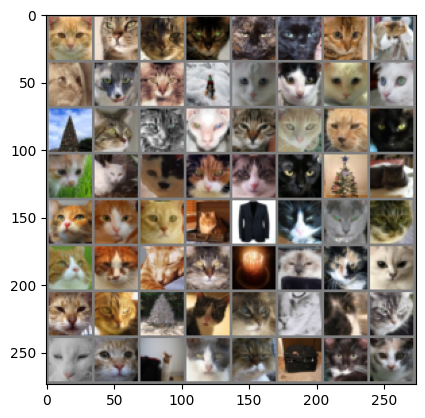

cat   cat   cat   cat   cat   cat   cat   cat   cat   cat   cat   random cat   cat   cat   cat   random cat   cat   cat   cat   cat   cat   cat   cat   cat   cat   cat   cat   cat   random cat   cat   cat   cat   cat   random cat   cat   cat   cat   cat   cat   cat   random cat   cat   cat   cat   cat   random cat   cat   cat   cat   cat   cat   cat   cat   cat   cat   random cat   cat  


In [19]:
import matplotlib.pyplot as plt
import numpy as np

def showimage(img):
  img = img /2 + 0.5 #unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.show()

#get random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

#show images
showimage(torchvision.utils.make_grid(images))
#show labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

**DEFINE CNN**

In [20]:
# import torch.nn as nn
# import torch.nn.functional as F

class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    # First convolutional layer (in_channels, out_channels, kernel_size) , out_channels = number of filters
    # 3 input channels, 6 output channels, 5x5 kernel size
    self.conv1 = nn.Conv2d(3,6,5)
    # Max pooling layer(kernel_size=2, stride=2)
    # 2x2 window, stride 2
    self.pool = nn.MaxPool2d(2,2)
    #(argument 2 of the first nn.Conv2d, and argument 1 of the second nn.Conv2d – they need to be the same number
    self.conv2 = nn.Conv2d(6, 16, 5)
    #fullyconnected layer 16*5*5 input features (after two 2x2 poolings), 10 output features (num of classes) (CIFAR10)
    self.fc1 = nn.Linear(16*5*5, 2)
    # OR multiple fc layers. last layer's output is number of classes. output of first is input of next (120-->84-->10)
    # self.fc1 = nn.Linear(16 * 5 * 5, 120)
    # self.fc2 = nn.Linear(120, 84)
    # self.fc3 = nn.Linear(84, 10)

  def forward(self,x):
    x = self.pool(F.relu(self.conv1(x))) #apply conv. then apply pooling
    x = self.pool(F.relu(self.conv2(x)))
    x = torch.flatten(x,1)
    x = self.fc1(x) #apply fullyconnected layer
    # OR multiple fc layers
    # x = F.relu(self.fc1(x))
    # x = F.relu(self.fc2(x))
    # x = self.fc3(x)
    return x





**SETUP DEVICE**

In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [22]:
device

'cuda'

### **Initiate Model**

In [23]:
model = CNN().to(device)

**Loss function**

In [24]:
# import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

### **Train**

In [25]:
for epoch in range(num_epochs):
  print(f"Epoch [{epoch +1 }/{num_epochs}]")
  for batch_index, (data,targets) in enumerate(tqdm(trainloader)):
    #Move data and targets to device (GPU/CPU)
    data = data.to(device)
    targets = targets.to(device)

    #Forward pass: compute model output
    scores = model(data)
    loss = criterion(scores,targets)

    #Backward pass: compute the gradients
    optimizer.zero_grad()
    loss.backward()

    # Optimization step: update model parameters
    optimizer.step()

Epoch [1/5]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:37<00:00,  1.88it/s]


Epoch [2/5]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:01<00:00, 60.10it/s]


Epoch [3/5]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:01<00:00, 55.46it/s]


Epoch [4/5]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:01<00:00, 61.80it/s]


Epoch [5/5]


100%|██████████████████████████████████████████████████████████████████████████████████| 71/71 [00:01<00:00, 62.77it/s]


### **Save and Load Model**

In [26]:
# Save model
PATH = './cifar_net.pth'
torch.save(model.state_dict(), PATH)

# Load model
# model = CNN()
# model.load_state_dict(torch.load(PATH, weights_only=True))

**Test on testdata**

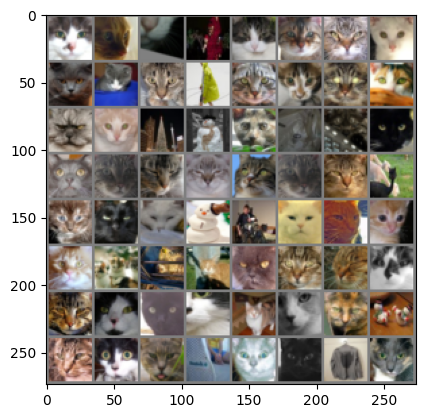

GroundTruth:  cat   cat   cat   random cat   cat   cat   cat   cat   cat   cat   random cat   cat   cat   cat   cat   cat   random random cat   random cat   cat   cat   cat   cat   cat   cat   cat   cat   random cat   cat   cat   random random cat   cat   cat   cat   cat   random cat   cat   cat   cat   cat   cat   cat   cat   cat   cat   cat   cat   random cat   cat   cat   random cat   cat   random cat  
Predicted:  cat   cat   cat   cat   cat   cat   cat   cat   cat   cat   cat   random cat   cat   cat   cat   cat   cat   cat   cat   cat   cat   cat   cat   cat   cat   cat   cat   cat   cat   cat   random cat   cat   cat   cat   cat   cat   cat   cat   cat   cat   cat   cat   cat   cat   cat   cat   cat   cat   cat   cat   cat   cat   cat   cat   cat   cat   cat   cat   cat   cat   cat   cat  


In [27]:

dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
showimage(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

#send images to gpu
images = images.to(device)

outputs = model(images)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(batch_size)))

### **Check Accuracy**

In [28]:
def check_accuracy(loader, model):
    """
    Checks the accuracy of the model on the given dataset loader.

    Parameters:
        loader: DataLoader
            The DataLoader for the dataset to check accuracy on.
        model: nn.Module
            The neural network model.
    """
    #if loader.dataset.train:
     #   print("Checking accuracy on training data")
    #else:
     #   print("Checking accuracy on test data")

    num_correct = 0
    num_samples = 0
    model.eval()  # Set the model to evaluation mode

    with torch.no_grad():  # Disable gradient calculation
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            # Forward pass: compute the model output
            scores = model(x)
            _, predictions = scores.max(1)  # Get the index of the max log-probability
            num_correct += (predictions == y).sum()  # Count correct predictions
            num_samples += predictions.size(0)  # Count total samples

        # Calculate accuracy
        accuracy = float(num_correct) / float(num_samples) * 100
        print(f"Got {num_correct}/{num_samples} with accuracy {accuracy:.2f}%")

    model.train()  # Set the model back to training mode

# Final accuracy check on training and test sets
check_accuracy(trainloader, model)
check_accuracy(testloader, model)

Got 4151/4512 with accuracy 92.00%
Got 1023/1128 with accuracy 90.69%


### **Visualize filters**

[Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1)), MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1)), Linear(in_features=400, out_features=2, bias=True)]

Layer  2


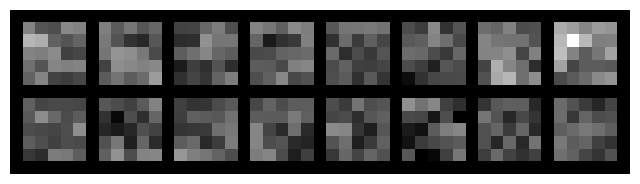

In [30]:
def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
        n,c,w,h = tensor.shape

        if allkernels: tensor = tensor.view(n*c, -1, w, h)
        elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

        rows = np.min((tensor.shape[0] // nrow + 1, 64))    
        grid = torchvision.utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
        plt.figure( figsize=(nrow,rows) )
        plt.imshow(grid.numpy().transpose((1, 2, 0)))

#layer 0 and 2 are conv2d layers
layer = 2

features = []
lmodel = CNN()
lmodel.load_state_dict(torch.load(PATH, weights_only=True))
for key,value in lmodel._modules.items():
    features.append(value)

print(features)
print("\nLayer ",layer)
filter = features[layer].weight.data.clone()
#print(f"COnv2d = {features[0].weight.data}")
visTensor(filter, ch=0, allkernels=False)

plt.axis('off')
plt.ioff()
plt.show()